# Network Serialization

In this short tutorial we explain how network serialization works and how to create custom networks with proper serialization.

In [1]:
%load ../../rapaio-bootstrap.ipynb

Adding dependency io.github.padreati:rapaio-lib:7.0.1
Solving dependencies
Resolved artifacts count: 1
Add to classpath: /home/ati/work/rapaio-jupyter-kernel/target/mima_cache/io/github/padreati/rapaio-lib/7.0.1/rapaio-lib-7.0.1.jar


Serialization is the process of saving an object to an external medium and loading it for later usage. Thus, for neural networks as it is the case for most of the machine learning models, this feature is critical. This allows one to separate the process of learning and inference, since both of them might have different requirements, and also allow one to use a model at a later time and/or on a different machine.

Usually in `rapaio` library the model instance is persisted. For neural networks this is different, however, what is saved and load is the model state. The *network state* consists in all the tensors which are involved in computation, either for inference or training, and defines the computational behavior of the neural network. 

The reason why a neural network model instance is not saved directly, but his state, it is a design decision. Creating custom neural networks should be considered first when you want to build a model and we don't want to interfere with the instance construction phase of a neural network (the code called in constructor). Saving and instantiating the model directly would create a parallel way to construct networks, a prone to errors process and hard to maintain. Since neural networks takes tensors as inputs, do computations which involves other tensors, and compute some outputs in the form of tensors, the involved tensors is the only critical part which needs to pe stored in a persistent way. 

Persisting and loading neural networks offline involves two stages. The first stage is always object creation, which basically means usinga constructor to create a new instance of the model. The second stage is to load its state from a persistent storage, state which will override the behavior of the newly created instance into the behavior of the persisted network. 

## Example of custom network

For illustration purposes we will use a custom network model, bring some data and train it. We define a function which takes a 4 dimensional input. We generate a random data set and split into test and train.

In [2]:
double fun4d(double x1, double x2, double x3, double x4) {
    return Math.sin(x1) * Math.cos(x2) + x3 + x4 * x4 + Math.sqrt(Math.abs(x1 + x3));
}

In [3]:
TensorManager tm = TensorManager.ofFloat();
tm.seed(42);

In [4]:
final int N = 1_000;
Tensor x = tm.randomTensor(Shape.of(N, 4), tm.random());
Tensor y = tm.zerosTensor(Shape.of(N));
for (int i = 0; i < N; i++) {
    DArray<?> row = x.value().selsq(0, i);
    y.value().setDouble(tm.random().nextDouble() / 100 + fun4d(row.getDouble(0), 
        row.getDouble(1), row.getDouble(2), row.getDouble(3)), i);
}


TabularDataset[] split = new TabularDataset(tm, x, y).trainTestSplit(0.2);
TabularDataset train = split[0];
TabularDataset test = split[1];

We then define a neural network to handle the regression problem.

In [5]:
static class Fun4dNetwork extends AbstractNetwork {
    final BatchNorm1D norm1;
    final Linear linear1;
    final ReLU relu1;
    final BatchNorm1D norm2;
    final Linear linear2;

    public Fun4dNetwork(TensorManager tm) {
        super(tm);
        norm1 = new BatchNorm1D(tm, 4);
        linear1 = new Linear(tm, 4, 1_000, true);
        relu1 = new ReLU(tm);
        norm2 = new BatchNorm1D(tm, 1_000);
        linear2 = new Linear(tm, 1_000, 1, true);
    }
    public Tensor forward11(Tensor x) {
        x = norm1.forward11(x);
        x = linear1.forward11(x);
        x = relu1.forward11(x);
        x = norm2.forward11(x);
        x = linear2.forward11(x);
        return x;
    }
}

In order to see that the network is viable we fit it on train data and test it.

In [6]:
Network nn = new Fun4dNetwork(tm);

int EPOCHS = 400;
int BATCH_SIZE = 100;

Optimizer optimizer = Optimizer.Adam(tm, nn.parameters()).lr.set(1e-3);

VarDouble trainLoss = VarDouble.empty().name("trainLoss");
VarDouble testLoss = VarDouble.empty().name("testLoss");

Loss loss = new MSELoss(tm);

for (int epoch = 1; epoch <= EPOCHS; epoch++) {

    nn.train();
    optimizer.zeroGrad();

    var batchOut = nn.batchForward(BATCH_SIZE, true, false, train.tensor(0));
    var lossOut = loss.batchForward(batchOut, train.tensor(1));

    double trainLossValue = lossOut.lossValue();
    trainLoss.addDouble(trainLossValue);

    Autograd.backward(lossOut.tensor());
    optimizer.step();

    nn.eval();
    Tensor outputs = nn.forward11(tm.var(test.darray(0)));
    lossOut = loss.forward(outputs, tm.var(test.darray(1)));
    double teLoss = lossOut.lossValue();
    testLoss.addDouble(teLoss);

    if (epoch == 1 || epoch % 25 == 0) {
        System.out.printf("Epoch: %d, Train loss: %.6f, test loss: %.6f\n", epoch, trainLossValue, teLoss);
    }
}


Epoch: 1, Train loss: 6.463082, test loss: 6.558301
Epoch: 25, Train loss: 1.342792, test loss: 1.395550
Epoch: 50, Train loss: 0.612419, test loss: 0.622492
Epoch: 75, Train loss: 0.263298, test loss: 0.259663
Epoch: 100, Train loss: 0.204112, test loss: 0.194072
Epoch: 125, Train loss: 0.181188, test loss: 0.172728
Epoch: 150, Train loss: 0.158991, test loss: 0.155328
Epoch: 175, Train loss: 0.137773, test loss: 0.137477
Epoch: 200, Train loss: 0.117931, test loss: 0.120677
Epoch: 225, Train loss: 0.100027, test loss: 0.105606
Epoch: 250, Train loss: 0.084605, test loss: 0.092792
Epoch: 275, Train loss: 0.071990, test loss: 0.082608
Epoch: 300, Train loss: 0.061805, test loss: 0.074530
Epoch: 325, Train loss: 0.053378, test loss: 0.068135
Epoch: 350, Train loss: 0.046240, test loss: 0.062288
Epoch: 375, Train loss: 0.040201, test loss: 0.057271
Epoch: 400, Train loss: 0.035062, test loss: 0.052875


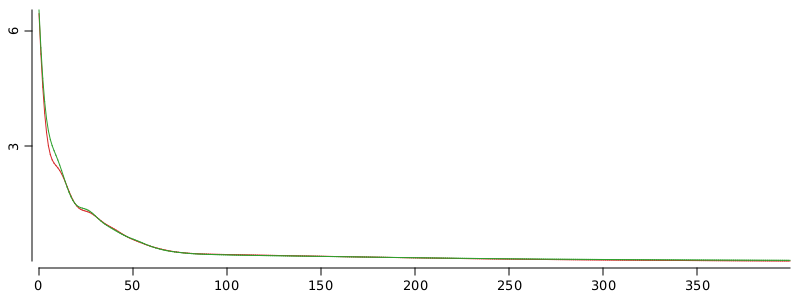

In [7]:
WS.image(lines(trainLoss, color(1), lwd(1)).lines(testLoss, color(2), lwd(1)), 800, 300);


As you can see the network do it's job. But the performance of the network is not important now. The point is that we have a network which is not in the initial state, its state changed after some hundred epochs on training data.

## Save network state

We want to use the network later, loaded from a persistent storage, which in our case is a file on disk. In order to save the network state we have to call one of the method named `saveState`. Let's save it to a file.

In [8]:
nn.saveState(new File("./fun4d-network.bin"));

The name of the file is not important, neither its extension. We used `.bin` for that purpose, but it can be actually anything, as long as we remember it.

### How save state works?

The `Network` models exposes its state through method `state()`. This method returns in a list all the tensors which are involved in neural network computations. Tensors have two main important properties: its value and its gradient. The gradient is a volatile information, since it can be changed after any kind of `Autograd.backward` call. Anyhow, the gradient values are relevant only to the optimizer and they are not involved in inferences. Thus, gradients are not relevant for serialization.

But tensors' values are important for serialization. The values of the tensors together with the code of forward methods determines completely the results of the inferences. Those values will be persisted. It is also relevant that network state maintains the order of those tensors, information which will be relevant when the state will be loaded from a persistent storage.

**Important note**

When you need to implement the method `state()` for a custom network it is very important to expose through network state the actual tensor instances, not a copy of those tensors. Tensors acts like containers for tensor values, in other words acts like references to those values. The same tensors will be used at loading the network state. If you expose a copy of the actual tensors, then that copy will be updated with the new value and your network will not receive its state.

## Creating a new instance of the network

Imagine now that we closed our main program. Thus we do not have a network object. We must create it. We should create a new instance of the network in a normal way. If we have different ways to create a network, with different parameters, it would be a good idea to create the new instance in the same way that we created the network instance who's state we persisted. 

In [9]:
TensorManager tm = TensorManager.ofFloat();
Network nn2 = new Fun4dNetwork(tm);

After we have a network instance of the same type and created in the same way as the network who's state we persisted before, we can load from the persistent storage the serialized network state into the new network instance. We do that by calling on of the methods named `loadState`.

In [10]:
nn2.loadState(new File("./fun4d-network.bin"));

That is all, actually.

### How load network state works

Loading the network state into a new network object works in the following way. Using the same `state()` method, the deserialization code have access to the tensors which will receive the new values. The deserialization code reads each value (which is an darray, actually) from the persistent storage, and sets that value to the corresponding tensor object from the network state. In human plain words, it overrides the values of the involved tensors with the values from the persistent storage. This is why it is important to expose the actual tensors through state method, and not some copy of them.

## Tensting the new network instance

We now have to networks, the original one and another one which was loaded from disk. They should behave in the same way. You can trust me or you can do a test. I urge you to chose the second way. 

To test the fact that those networks produces the same results we will predict the same input features with both networks. After that we see if there is any difference between them.

In [11]:
var prediction1 = nn.forward11(train.tensor(0)).value();
var prediction2 = nn2.forward11(train.tensor(0)).value();

In [12]:
// compute the sum of absolute differences
prediction1.sub(prediction2).abs().sum();

0.0

As you can see there is no difference. Thus we can conclude that, at least for inference purposes, the networks are the same.

## Other aspects of network serialization

The network serialization uses a binary protocol which was implemented in the library to store those values. There is also a text protocol which was written for debugging purpose. That protocol can be used to see the actual stored content in a textual format. If you want to play with it you can use some code like: `nn.saveState(TextAtomProtocol.outputToStream(System.out))`.

You can serialize a network state in other type of storages. For that purpose use the universal `OutputStream` interface, since there are `saveState` and `loadState` state methods which handles those interfaces. 